# **1. Perkenalan Dataset**
<br>Notebook ini memanfaatkan berkas `namadataset_raw/demand_history.csv`
<br>*Tujuan*: menyiapkan pipeline EDA → pre-processing → feature engineering sebagai fondasi model peramalan permintaan produk.

# **2. Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.stats as st

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

## Konfigurasi Global

In [2]:
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

RAW_PATH  = Path("../namadataset_raw/demand_history.csv")
SAVE_PATH = Path("preprocessing/namadataset_preprocessing/clean.csv")
SEED = 42

# **3. Memuat Dataset**

In [3]:
df = pd.read_csv(
    RAW_PATH,
    parse_dates=["Date"],         
    dayfirst=False,
    infer_datetime_format=True,
    low_memory=False
)

C:\Users\Rakha\AppData\Local\Temp\ipykernel_23184\1993001970.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


In [4]:
print("Initial shape :", df.shape)
df.head()

Initial shape : (1048575, 5)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


# **4. Info & Missing Values** 

## 4.1 Info & Missing Values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1048575 non-null  object        
 1   Warehouse         1048575 non-null  object        
 2   Product_Category  1048575 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1048575 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 40.0+ MB


In [6]:
na = df.isna().mean().sort_values(ascending=False)
na[na > 0]

Date    0.010718
dtype: float64

## 4.2 Pembersihan Awal

In [7]:
df_clean = df.copy()

In [8]:
def parse_order(x: str) -> int:
    """
    1) Hilangkan spasi
    2) Ganti tanda kurung '(123)' --> -123
    3) Konversi ke int
    """
    x = str(x).strip()
    if x.startswith('(') and x.endswith(')'):
        x = '-' + x[1:-1]
    return int(x)

In [9]:
df_clean["Order_Demand"] = df_clean["Order_Demand"].apply(parse_order)

In [10]:
df_clean = df_clean.dropna(subset=["Date"])


In [11]:
df_clean.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


## 4.3 Statistik Deskriptif

In [12]:
desc = df_clean["Order_Demand"].describe(percentiles=[.25,.5,.75,.9,.95])
skw  = st.skew(df_clean["Order_Demand"])
krt  = st.kurtosis(df_clean["Order_Demand"], fisher=False)  # pearson kurtosis
print(desc)
print(f"Skewness  : {skw:.2f}")
print(f"Kurtosis  : {krt:.2f}")

count    1.037336e+06
mean     4.920153e+03
std      2.907840e+04
min     -9.990000e+05
25%      1.900000e+01
50%      3.000000e+02
75%      2.000000e+03
90%      1.000000e+04
95%      2.000000e+04
max      4.000000e+06
Name: Order_Demand, dtype: float64
Skewness  : 31.30
Kurtosis  : 1862.18


| Ukuran      | Nilai | Pesan Utama | 
| ----------- | ----------- | ----------- |
| Count      | 1 037 336 baris | Setelah membuang baris bertanggal NA, inilah jumlah record sah.      |
| mean | 4.920 | Order rata-rata 4,9 ribu unit per transaksi |
| median 50% | 300 | Separuh transaksi hanya ≤ 300 unit |
| 25% - 75% | 1.9 -> 2.0 | 50 % terbesar populasi berada di rentang lebar (19 – 2 000) |
| 90 % / 95 %	| 10 000 / 20 000 | Hanya 5 % transaksi yang di atas 20 k unit|
| min |  ‑999 000 | Ada record negatif amat besar (kemungkinan kesalahan data atau penandaan retur) |
| max | 	 4 000 000 | Ada order empat juta unit—outlier ekstrem |
| std |  29 078 | Dispersi sangat tinggi|

- skewness 31,3 menandakan skew kanan ekstrem—ekor kanan jauh ber­­tarik
- kurtosis 1 862 Distribusi “fat‑tail” parah; outlier jauh lebih sering daripada distribusi normal.

# **5. Data Preprocessing**

## 5.1 Buang Nilai Aneh & Outlier Ekstrem

In [13]:
df_clean = df_clean[df_clean["Order_Demand"] > 0]          # buang negatif & nol
df_clean = df_clean[df_clean["Order_Demand"] < 1_000_000]  # buang outlier ekstrem 4 jt; sentinel -999k sudah kena di atas

## 5.2 Winsorize p99

In [14]:
p99 = df_clean["Order_Demand"].quantile(0.99)
df_clean["Order_Demand"] = np.where(df_clean["Order_Demand"] > p99, p99, df_clean["Order_Demand"])

## 5.3 Transformasi Log

In [15]:
df_clean["Log_Demand"] = np.log1p(df_clean["Order_Demand"])

## 5.4 Fitur Kalendar

In [16]:
df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean = df_clean.sort_values(["Product_Code", "Date"])
df_clean["day_of_week"]  = df_clean["Date"].dt.dayofweek
df_clean["week_of_year"] = df_clean["Date"].dt.isocalendar().week.astype(int)
df_clean["month"]        = df_clean["Date"].dt.month
df_clean["year"]         = df_clean["Date"].dt.year

## 5.5 Trend & Seansonality Ringkas

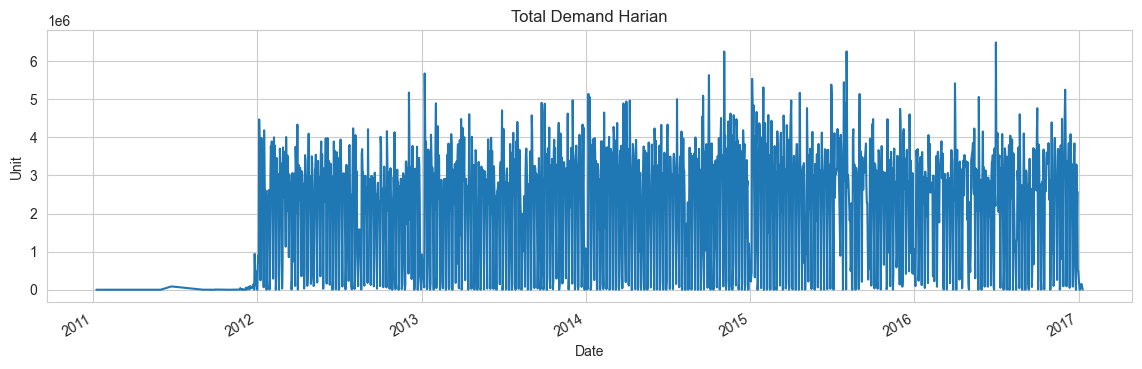

In [17]:
daily = df_clean.groupby("Date")["Order_Demand"].sum()

plt.figure(figsize=(14,4))
daily.plot()
plt.title("Total Demand Harian")
plt.ylabel("Unit")
plt.show()

In [18]:
stl = STL(np.log1p(daily), period=7)
res = stl.fit()
res.plot().set_size_inches(12,8)
plt.tight_layout()

NameError: name 'STL' is not defined

# **6. Feature Engineering**

## 6.1 Lag & Rolling Feature

In [ ]:
group = df_clean.groupby("Product_Code")

for lag in [1, 7, 28]:
    df_clean[f"lag_{lag}"] = group["Log_Demand"].shift(lag)

for win in [7, 28]:
    df_clean[f"roll_mean_{win}"] = group["Log_Demand"].shift(1).rolling(win).mean()


In [ ]:
df_clean = df_clean.dropna().reset_index(drop=True)
print("After lag/rolling:", df_clean.shape)

After lag/rolling: (943504, 15)


## 6.2 Encoding Kategorikal

In [ ]:
cat_cols  = ["Product_Category", "Warehouse", "day_of_week"]
num_cols  = [c for c in df.columns if c.startswith(("lag_", "roll_mean_"))]
target    = "Log_Demand"

In [ ]:
ohe = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer(
    [("cat", ohe, cat_cols)],
    remainder="passthrough"
)